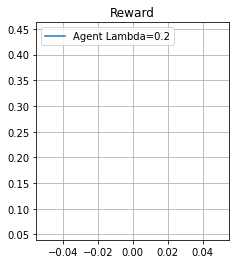

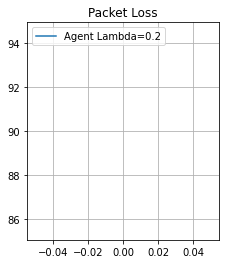

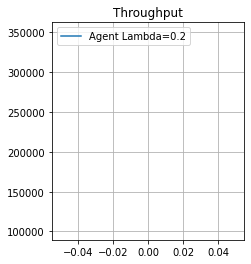

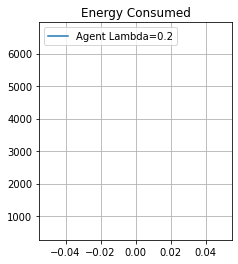

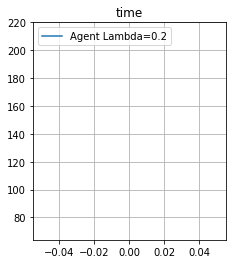

KeyboardInterrupt: 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
os.environ["CUDA_VISIBLE_DEVICE"] = ""

from collections import defaultdict
import matplotlib.pyplot as plt
import random
import math
import dill
import numpy as np
import argparse
from ns3gym import ns3env
import pandas as pd
import easydict
from IPython.display import clear_output


args = easydict.EasyDict({
        "start": 1,
        "iterations": 2,
        "Agent": 1,
        "verbose": 1,
        "Mobility": 1,
        "distance": 20,
        'stat': 1,
        "packetPerSec":60000,
        "energy":10.0,
        "channelWidth":160,
        "lambda_":0.5,
        "num_agents": 3
})

# args = parser.parse_args()
startSim = bool(args.start)
iterationNum = int(args.iterations)
Agent = int(args.Agent)
verbose = int(args.verbose)
distance = int(args.distance)
constant_distance = True if int(args.Mobility) == 1 else False
stat = int(args.stat)
packetPerSec = int(args.packetPerSec)
energy_ = float(args.energy)
channelWidth = int(args.channelWidth)
lambda_ = float(args.lambda_)
ag = int(args.num_agents)


port = 6090
simTime = 10 # seconds
envStepTime = 0.005  # seconds
seed = 0
simArgs = {"--simTime": simTime,
           "--testArg": 123,
           "--nodeNum": 3,
           "--distance": distance,
           "--minstrel": False,
           "--constant_distance": constant_distance,
           "--packetPerSec": packetPerSec,
           "--energy_": energy_,
           "--lambda_": lambda_}
debug = False

env = ns3env.Ns3Env(port=port, stepTime=envStepTime, startSim=startSim, simSeed=seed, simArgs=simArgs, debug=debug)
s=env.reset()

ob_space = env.observation_space
ac_space = env.action_space
print("Observation space: ", ob_space,  ob_space.dtype)
print("Action space: ", ac_space, ac_space.dtype)
state_dim = (len(s)-2,)
print(state_dim)
peraction = 10
total = peraction**2
actions = np.vstack(np.array([[[n, o] for o in range(peraction)] for n in range(peraction)]))
n_actions = len(actions)
print("Number of Actions: ", n_actions)



class QLearningAgent: 

    def __init__(self, alpha, epsilon, discount):
        
        self.total = 10*10
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0.0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        state =tuple(state)
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        state = tuple(state)
        self._qvalues[state][action] = value
    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = Q_Next_state-Action.
        """
        possible_actions = list(range(100))

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        max_value = float("-inf")
        for action in possible_actions:
          action_value = self.get_qvalue(state, action)
          if action_value > max_value:
            max_value = action_value

        return max_value
    def update(self, state, action, reward, next_state, at):
        """
       
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        Q_value = self.get_qvalue(state, action)
        value = self.get_qvalue(next_state, at)
        Q_value = Q_value + learning_rate * (reward + (gamma * value) - Q_value)
        self.set_qvalue(state, action, Q_value )

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = range(100)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        
        all_actions = [self.get_qvalue(state, action) for action in possible_actions]


        return np.argmax(all_actions)

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        """

        # Pick Action
        possible_actions = list(range(100))

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
  
        # agent parameters:
        best_action = self.get_best_action(state)
        random_choice = np.random.choice(possible_actions)
     
        chosen_action = np.random.choice( [best_action, random_choice], p = [1-self.epsilon, self.epsilon] )

        return chosen_action


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, at, done):

        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, at, done)

        # add data to storage
        if len(self) < self._maxsize:
            self._storage.append(data)
        else:
          self._storage.pop(0)
          self._storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        next_obs_action_batch: np.array
            next set of action taken at next state
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        if batch_size < len(self):
          new = random.sample(self._storage, batch_size,)
        else:
          new = random.sample(self._storage, len(self),)

        # collect <s,a,r,s',a' done> for each index
        states = []
        actions = []
        rewards = []
        next_states = []
        at_ = []
        is_done = []

        for st in new:
          state, action, reward, next_state, at, done = st
          states.append(state)
          actions.append(action)
          rewards.append(reward)
          next_states.append(next_state)
          at_.append(at)
          is_done.append(done)

        return (
            np.array(states) ,
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(at_),
            np.array(is_done),
        )

def play_and_train(env, agent, replay = None, replay_batch_size=512, verbose=0):
    """
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward

    """
    en = 30
    total_reward = 0.0
    s = env.reset()
    t = 0
    en = s.pop()
    th = s.pop()
    pkt_drop = s.pop()

    a = agent.get_action(s)
    s[0] = int(s[0]/5000*10)*10
    s = [int(f) for f in s]
    
    while 1:
#         s[0] = getlevel((s[0]/5000)*100)
        t+=1
        # get agent to pick action given state s.
        
        next_s, r, done, _ = env.step(actions[a])
        next_s[0] = int(next_s[0]/5000*10)*10
        
        if verbose:
          print("---obs, action, reward, done, Packet_dropped: ", t, th, s, actions[a],  np.round(r, 5), pkt_drop, en)
        
        en += next_s.pop()
        th += next_s.pop()
        pkt_drop = next_s.pop()
        next_s = [int(f) for f in next_s]
        
        battery_level = next_s[-1]
        # train (update) agent for state s

        at = agent.get_action(next_s)

        agent.update(s, a, r, next_s, at)


        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            replay.add(s, a, r, next_s, at, done)
        
            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            s_, a_, r_, next_s_, at_, done_ = replay.sample(replay_batch_size)
            batch = replay_batch_size if len(replay) > replay_batch_size else len(replay)
            for i in range(batch):
                # print(i)
                agent.update(s_[i], a_[i], r_[i], next_s_[i], at_[i])
        a = at
        s = next_s
        total_reward += np.round(r, 10).item()
        if done:
            break

    return total_reward, pkt_drop, battery_level, en, th, 

def parallel(agents, environments=[], verbose=1, replay=True, replay_batch_size=512):
    """
    - run a full game for Agents in parallel, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward for each agents as well as packets 

    """

    time = [0 for i in range(len(environments))]
    total_reward = [0.0 for i in range(len(environments))]
    done_flag = [0 for i in range(len(environments))] 
    if replay:
        buffer = []
        for _ in range(len(environments)):  
            buffer.append(ReplayBuffer(100000)) 
    s_env = []
    energy = []
    th = []
    consumed = []
    pkt_drops = []
    all_done = False
    actions_ =  []
    for i, agent in enumerate(agents):
        env = environments[i]
        s = env.reset()
        consumed.append(s.pop())
        th.append(s.pop())
        pkt_drops.append(s.pop())
        s[0] = int(s[0]/5000*10)*10
        s = [int(f) for f in s]
        s_env.append(s)
        actions_.append(agent.get_action(s))    
    while sum(done_flag)<len(environments):

        for i in range(len(environments)):
            
            env = environments[i]
            agent = agents[i]
            
            if done_flag[i]:
                continue

            s = s_env[i]
            a = actions_[i]
            next_s, r, done, _ = env.step(actions[a])           
            consumed[i] += next_s.pop()
            th[i] += next_s.pop()
            pkt_drops[i] = next_s.pop()            
            next_s[0] = int(next_s[0]/5000*10)*10
            next_s = [int(f) for f in next_s]          
            at = agent.get_action(next_s)           
            agent.update(s, a, r, next_s, at)
            if verbose:
                print("---time, obs, action, throughput, energy, done", i,  time[i], s, actions[a],  r, total_reward[i], done_flag[i], pkt_drops[i], consumed[i])
                
            if replay:
                # store current <s,a,r,s'> transition in buffer
                buffer[i].add(s, a, r, next_s, at, done)

                # sample replay_batch_size random transitions from replay,
                # then update agent on each of them in a loop
                s_, a_, r_, next_s_, at_, done_ = buffer[i].sample(replay_batch_size)
                batch = replay_batch_size if len(buffer[i]) > replay_batch_size else len(buffer[i])
                for j in range(batch):
                    # print(i)
                    agent.update(s_[j], a_[j], r_[j], next_s_[j], at_[j])
            time[i]+=1
            s_env[i] = next_s
            actions_[i] = at
            total_reward[i] += r
            if done:
                done_flag[i] =1

    return total_reward, th, pkt_drops, consumed, time

def agents_init(n_agents=3):
    "Initialize Number of Agents"
    return [QLearningAgent( \
                alpha=0.2, epsilon=1, discount=0.9)  for _ in range(n_agents)]

def env_init(n_env=3, simtime=10, envStepTime = 0.005, seed= 0, \
             lambda_list=[0.8, 0.5, 0.2], ports = [7767, 8877, 9987], distance=10, ):
    "Initialize Number of Environments"
             
    environments = []
    for i in range(n_env):
        port = ports[i]
        simTime = simtime # seconds
        energy_ = float(simtime)

        envStepTime = envStepTime  # seconds
        seed = 0
        simArgs = {"--simTime": simTime,
           "--testArg": 123,
           "--nodeNum": 3,
           "--distance": distance,
           "--minstrel": False,
           "--constant_distance": True,
           "--packetPerSec": 60000,
           "--energy_": energy_,
           "--lambda_": lambda_list[i]}


        debug = False

        env = ns3env.Ns3Env(port=port, stepTime=envStepTime, startSim=1, simSeed=seed, simArgs=simArgs, debug=debug)

        environments.append(env)
        
    return environments

def save(agents):
    with open(f"new__model.pk" , "wb") as f:
        dill.dump(agents[0], f)
    with open(f"lambda0.5__model.pk" , "wb") as f:
        dill.dump(agents[1], f)
    with open(f"lambda0.2__model.pk" , "wb") as f:
        dill.dump(agents[0], f)


def load_agents (num_agents = 3, epsilon=1):
    agents = []

    for _ in range(num_agents):
        with open(f"new__model.pk" , "rb") as f:
                agent = dill.load(f)
                agent.epsilon = epsilon
                agents.append(agent)
        with open(f"lambda0.5__model.pk" , "rb") as f:
                agent = dill.load(f)
                agent.epsilon = epsilon
                agents.append(agent)
        with open(f"lambda0.2__model.pk" , "rb") as f:
                agent = dill.load(f)
                agent.epsilon = epsilon
                agents.append(agent)



def run_and_plot(agents, environments):
    epochs = 1000
    ret = []
    visual = 10

    for i in range(epochs):
        total_reward, th, pkt_drops, consumed, time = parallel(agents, environments = environments, verbose=0)
        ret.append([total_reward, th, pkt_drops, consumed, time])
        for agent in agents:
            agent.epsilon=agent.epsilon*0.999
        
        if i%visual==0 or i==epochs-1:
            array = np.array(ret)
            
            
            save(agents)
            with open(f"data_.pk" , "wb") as f:
                dill.dump(array, f)
            
            
            clear_output(True)
            plt.figure(figsize=[20, 4])
            plt.subplot(1, 5, 1)
            plt.title("Reward")
            for i in range(len(agents)):  
                plt.plot(array[:, 0, i])
            plt.legend(['Agent Lambda=0.2'],loc='upper left')
            plt.grid()


            plt.figure(figsize=[20, 4])
            plt.subplot(1, 5, 2)
            plt.title("Packet Loss")
            for i in range(len(agents)):  
                plt.plot(array[:, 2, i])
            plt.legend(['Agent Lambda=0.2'],loc='upper left')
            plt.grid()
            
            plt.figure(figsize=[20, 4])
            plt.subplot(1, 5, 3)
            plt.title("Throughput")
            for i in range(len(agents)):  
                plt.plot(array[:, 1, i])
            plt.legend(['Agent Lambda=0.2'],loc='upper left')
            plt.grid()
            
            
            plt.figure(figsize=[20, 4])
            plt.subplot(1, 5, 4)
            plt.title("Energy Consumed")
            for i in range(len(agents)):  
                plt.plot(array[:, 3, i])
            plt.legend(['Agent Lambda=0.2'],loc='upper left')
            plt.grid()
            
            plt.figure(figsize=[20, 4])
            plt.subplot(1, 5, 5)
            plt.title("time")
            for i in range(len(agents)):  
                plt.plot(array[:, 4, i])
            plt.legend(['Agent Lambda=0.2'],loc='upper left')
            plt.grid()

            plt.show() 
if ag >1:
    agents = agents_init(ag)
    environments = env_init(n_env=ag, simtime=10, envStepTime = 0.005, seed= 0, \
                lambda_list=[0.8, 0.5, 0.2], ports = [7767, 8877, 9987], distance=10, )
else:
    agent = QLearningAgent(
    alpha=0.2, epsilon=1, discount=0.99) 
    replay = ReplayBuffer(100000)  
    
print("All Checked")
print("Number of Environments =", len(environments))
run_and_plot(agents, environments)
